In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
df_orig = pd.read_csv("weatherAUS.csv") #importing the dataset
df_orig['Date'] = pd.to_datetime(df_orig['Date']) #transform date column into a datetime format (year-month-day) 

In [3]:
df_orig.head() #getting a preview of the first 5 rows in the dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


# Data Preprocessing

In [4]:
# Drop RISK_MM as it will bias our model.
df = df_orig.drop('RISK_MM', axis=1)

RISK_MM (amount of rainfall in mm for the next day) should be dropped from the dataset because it contains information directly related to our target variable (RainTomorrow).

In [5]:
df.isna().sum().sort_values(ascending=False) / len(df_orig)

Sunshine         0.476929
Evaporation      0.427890
Cloud3pm         0.401525
Cloud9am         0.377353
Pressure9am      0.098556
Pressure3pm      0.098324
WindDir9am       0.070418
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir3pm       0.026570
Humidity3pm      0.025388
Temp3pm          0.019171
WindSpeed3pm     0.018496
Humidity9am      0.012476
Rainfall         0.009888
RainToday        0.009888
WindSpeed9am     0.009480
Temp9am          0.006358
MinTemp          0.004480
MaxTemp          0.002265
Location         0.000000
RainTomorrow     0.000000
Date             0.000000
dtype: float64

In [6]:
# Replace NaN values with median of the columns
df.fillna(df.median(), inplace=True)

We notice that our columns have missing values. 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am' have a significant amount of missing values

In order to get rid of these missing values, I decided to replace them with the median of their respective column.

In [7]:
df.isna().sum().sort_values(ascending=False) / len(df_orig)

WindDir9am       0.070418
WindGustDir      0.065615
WindDir3pm       0.026570
RainToday        0.009888
RainTomorrow     0.000000
Location         0.000000
MinTemp          0.000000
MaxTemp          0.000000
Rainfall         0.000000
Evaporation      0.000000
Sunshine         0.000000
WindGustSpeed    0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure9am      0.000000
Pressure3pm      0.000000
Cloud9am         0.000000
Cloud3pm         0.000000
Temp9am          0.000000
Temp3pm          0.000000
Date             0.000000
dtype: float64

Notice that we still have missing values. These are missing from rows that contain categorical values and for which we couldn't compute a median.

For these values, it makes more sense to replace the missing value with the last known value. For example, if we are missing the wind direction for a day, it is fair to assume that it has stayed the same as the previous day.

In [8]:
# Replace categorical values with value in previous row using forward fill 
categorical_cols = ['WindGustDir', 'Location', 'WindDir9am', 'WindDir3pm']
df[categorical_cols + ['RainToday']] = df[categorical_cols + ['RainToday']].fillna(method='ffill')

# Feature Engineering

In [9]:
# Split the Date column into Day, Month and Year columns.
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Drop the original Date column.
df.drop(['Date'], axis=1, inplace=True)

The model won't pick up seasonal patterns that are represented by the month and day if we leave the date as one string feature. Instead, we split it into three different features: day, month and year. This is very useful since it will be more likely to rain in some months than others.

In [10]:
# Convert categorical columns into one-hot encoded vectors
df = pd.get_dummies(df, columns=categorical_cols)

# Replace boolean with int vals
rain_bool_cols = ["RainToday", "RainTomorrow"]
df[rain_bool_cols] = df[rain_bool_cols].replace({'Yes':1, 'No':0})

Here we convert the categorical columns found into one-hot encoded vectors.

We also notice that some columns (RainToday, RainTomorrow) have boolean values (yes/no), we simply replace them with int values (0, 1 respectively).



In [11]:
print('Number of columns in original dataframe: %s.' % len(df_orig.columns))
print('Number of columns in new dataframe: %s.\n' % len(df.columns))

windir_cols = [colname for colname in df.columns if "WindDir9am" in colname]
print("WinDir9am column expanded into: %s" % ', '.join(windir_cols))

Number of columns in original dataframe: 24.
Number of columns in new dataframe: 118.

WinDir9am column expanded into: WindDir9am_E, WindDir9am_ENE, WindDir9am_ESE, WindDir9am_N, WindDir9am_NE, WindDir9am_NNE, WindDir9am_NNW, WindDir9am_NW, WindDir9am_S, WindDir9am_SE, WindDir9am_SSE, WindDir9am_SSW, WindDir9am_SW, WindDir9am_W, WindDir9am_WNW, WindDir9am_WSW


The number of columns naturally increased with one-hot encoding.

# Normalizing Data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.516509,0.523629,0.001617,0.033103,0.586207,0.294574,0.153846,0.275862,0.71,0.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.375000,0.565217,0.000000,0.033103,0.586207,0.294574,0.030769,0.252874,0.44,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.504717,0.576560,0.000000,0.033103,0.586207,0.310078,0.146154,0.298851,0.38,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.417453,0.620038,0.000000,0.033103,0.586207,0.139535,0.084615,0.103448,0.45,0.16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.613208,0.701323,0.002695,0.033103,0.586207,0.271318,0.053846,0.229885,0.82,0.33,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To normalize data, I used sklearn library that already contains built-in scikit-learn methods such as MinMaxScaler, RobustScaler, Normalizer, etc. 

The reason we normalize data is that features have different units and for that reason different scales. Transforming data to have a similar scale definitely helps in the performance of the model. I opted for MinMaxScaler where the range returned is between 0 and 1.

# Training 

In [13]:
def get_accuracy(y, y_hat):
    # flatten both vectors to make sure they have 1 column
    y = y.flatten()
    y_hat = y_hat.flatten()
    n_correct = np.sum(y == y_hat)
    return n_correct / y.size

def to_bool(y):
    return np.around(y)

def initialize(dim):
    b = 0
    w = np.random.rand(dim, 1) 
    return w, b

def sigmoid(s):
    return ((1 / (1 + np.exp(-s))))

def cross_entropy(y_hat, Y):
    """y_hat is the predicted value, Y is the real value."""
    return np.sum(Y * np.log(y_hat) + (1 - Y) * np.log(1 - y_hat))

def feed_forward(w, b, X):
    """returns predicted values for x_test"""
    z = np.dot(w.T, X) + b  # calculate the weighted sum
    y_hat = sigmoid(z)  # apply activation function to get prediction
    return y_hat

def gradient_descent(X, Y, epochs, learning_rate):
    n_training, n_weights = np.array(x_train).shape
    w, b = initialize(dim=n_weights)
    for i in range(epochs):
        y_hat = feed_forward(w, b, X)
        cost = -(1 / n_training) * cross_entropy(y_hat, Y)
        dz = y_hat - Y
        dw = (1 / n_training) * np.dot(X, dz.T)
        db = (1 / n_training) * np.sum(dz)
        w = w - learning_rate * dw
        b = b - learning_rate * db
    
    return w, b

In order to minimize the cost function, gradient descent is used. Some of the calculations needed for calculating gradient descent such as cross entropy, feed forward, sigmoid and initialize are implemented as outter functions to make it more clear. Another function get_accuracy is used to calculate the accuracy of the model after testing it. To_bool is a helper function used to round the given value.

In [14]:
from sklearn.model_selection import train_test_split
x = df[df.columns.drop('RainTomorrow')] # keep only the features
y = df['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

We split our dataset into training and testing. For this I used a 20% test split. The built-in function I used shuffles the dataset before sampling. This is very important. Not doing so will induce bias in the model because the original dataframe is sorted by data and location. Therefore, if it samples the dataframe without shuffling, it will take the first 80% as training and leave the last 20% for testing. This last 20% will potentially be sampled from the same location and nearby dates.

In [15]:
x_train_np = np.array(x_train).T
y_train_np = np.array(y_train).T

epochs = 1000
learning_rate = 0.05
w, b = gradient_descent(x_train_np, y_train_np, epochs=epochs, learning_rate=learning_rate) # Train the model.

In [16]:
y_hat = feed_forward(w, b, np.array(x_test).T) # get the model's predicted output

y_hat_bool = to_bool(y_hat.T) # convert y_hat_test into array of bools
y_test_np = np.array(y_test) # actual labels

In [17]:
accuracy = get_accuracy(y=y_test_np, y_hat=y_hat_bool)
print("The model's accuracy using %s epochs and a %.3f learning rate is %.3f" % (epochs, learning_rate, accuracy))

The model's accuracy using 1000 epochs and a 0.050 learning rate is 0.811


# Exploring Gradient Descent

In the previous section, we ran gradient descent with a pre-defined learning rate.

Let's see how the learning rate affects the way with which the model converges towards the minimum.

In [18]:
def modified_gradient_descent(X, Y, epochs, learning_rate):
    n_training, n_weights = np.array(x_train).shape
    w, b = initialize(dim=n_weights)
    costs = []
    for i in range(epochs):
        y_hat = feed_forward(w, b, X)
        cost = -(1 / n_training) * cross_entropy(y_hat, Y)
        costs.append(cost)
        dz = y_hat - Y
        dw = (1 / n_training) * np.dot(X, dz.T)
        db = (1 / n_training) * np.sum(dz)
        w = w - learning_rate * dw
        b = b - learning_rate * db
    
    return costs

We introduce modified_gradient_decent which returns the "history" of costs in each epoch.

In [19]:
learning_rates = [0.5, 0.1, 0.01, 0.001, 0.0001]


costs_per_learning_rate = []

# Run gradient descent for each learning_rate and return the stored costs
for learning_rate in learning_rates:
    costs = modified_gradient_descent(x_train_np, y_train_np, epochs=epochs, learning_rate=learning_rate)
    costs_per_learning_rate.append(costs)

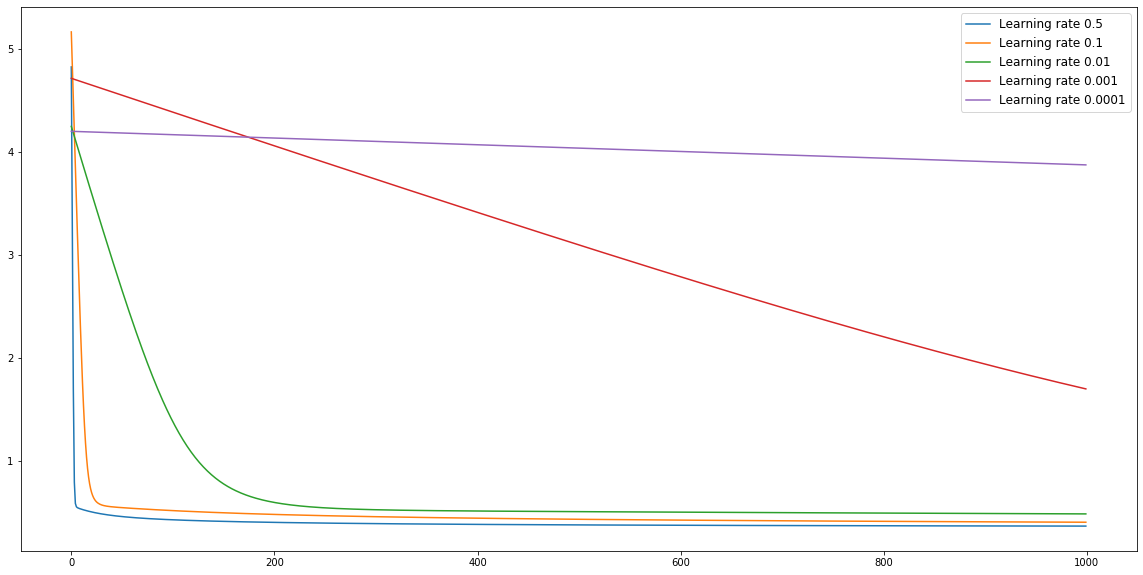

In [28]:
plt.rcParams["figure.figsize"] = (20,10)

for learning_rate, costs in zip(learning_rates, costs_per_learning_rate):
    plt.plot(costs, label='Learning rate %s' % learning_rate)

plt.legend(prop={'size': 12})
plt.show()

From the plot, we notice that the lower the learning rate is the slower the function is to converge.

Let's see what happens when we use a bigger learning rate

In [30]:
learning_rate = 5

# Run gradient descent for learning rate of 5
costs = modified_gradient_descent(x_train_np, y_train_np, epochs=epochs, learning_rate=learning_rate)

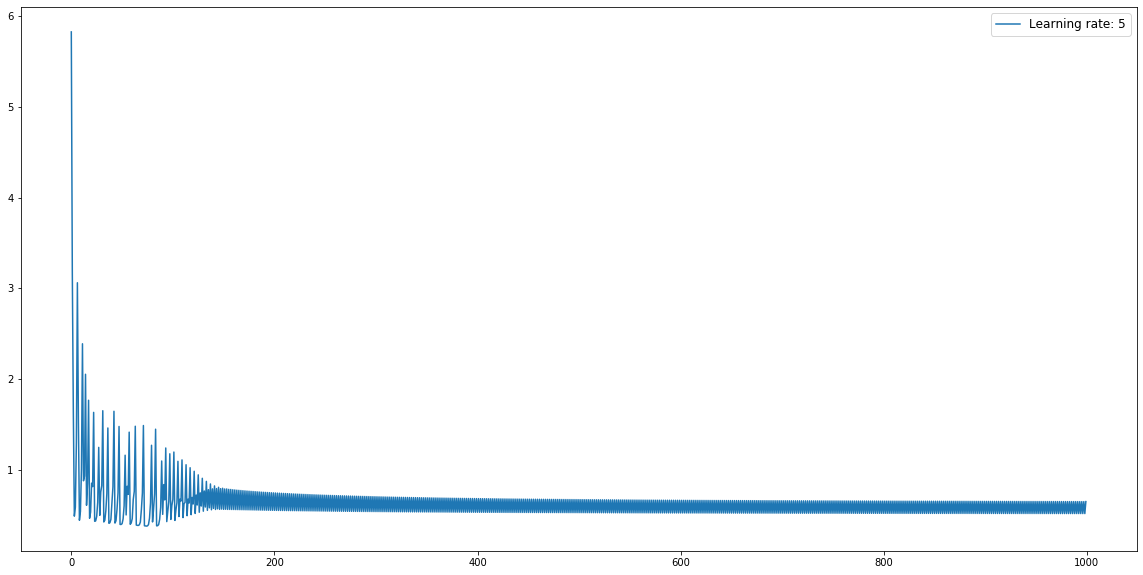

In [31]:
plt.plot(costs, label='Learning rate: 5')

plt.legend(prop={'size': 12})
plt.show()

As we can see, the cost oscillates a lot. This is because our gradient descent algorithm constantly misses the minimum because of the high learning rate. Therefore, blindly increasing the learning rate will not necessarily result in faster/better models.

# Write tests to csv

In [64]:
test_df = x_test.copy() # copy features from test rows
test_df.loc[:, 'RainTomorrow'] = y_test # add labels

test_df.to_csv('test_results.csv')